In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install tensorflow_decision_forests

In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
# import tensorflow_decision_forests as tfdf

import matplotlib as mpl
import matplotlib.pyplot as plt


import os
import tempfile

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
train_data_path = '/content/drive/MyDrive/thesis/data/train_set_2.csv'
test_data_path = '/content/drive/MyDrive/thesis/data/test_set_2.csv'


In [6]:
train_dataset = pd.read_csv(train_data_path, sep =";", index_col=[0])
train_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,fit_class
ENSMUSG00000022540,-4.0,4.0,-3.0,-1.0,1.0,2.0,6.0,2.0,-2.0,1.0,...,0.0,2.0,1.0,-4.0,-1.0,0.0,1.0,3.0,0.0,2
ENSMUSG00000080723,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000029335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000108532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
ENSMUSG00000046367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# get counts for each class
bi, poo, others = np.bincount(train_dataset['fit_class'])
total = bi + poo + others
print(f'Total: {total}')
print(f'Biallelic Class: {bi} ({round((100 * bi / total), 2)}% of total)')
print(f'Parent of Origin Class: {poo} ({round((100 * poo / total), 2)}% of total)')
print(f'Other Classes: {others} ({round((100 * others / total), 2)}% of total)')


Total: 3094
Biallelic Class: 2146 (69.36% of total)
Parent of Origin Class: 38 (1.23% of total)
Other Classes: 910 (29.41% of total)


In [8]:
# compute initial bias for the model to be defined later, based on frequency of each class

### To solve that set of nonlinear equations, use scipy fsolve
### https://stackoverflow.com/questions/60307239/setting-bias-for-multiclass-classification-python-tensorflow-keras
from scipy.optimize import fsolve
from math import exp

# define the frequency of different classes
f=(bi / total, poo / total, others / total)

# define the equation 
def eqn(x, frequency):
  sum_exp = sum([exp(x_i) for x_i in x])
  return [exp(x[i])/sum_exp - frequency[i] for i in range(len(frequency))]

# calculate bias init
bias_init = fsolve(func=eqn,x0=[0]*len(f),args=(f,)).tolist()

bias_init 



[1.630563717718403, -2.40321104574351, 0.7726473940385223]

In [9]:
# for training
# separating dataset into feature part and label part
y = train_dataset.iloc[:,-1]
X = train_dataset.iloc[:,:-1]
X.shape, y.shape

((3094, 682), (3094,))

In [10]:
# divide dataset into training and validation sets, for cross valuidation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
# converting pandas df to np array, as few functions used would only accept np arrays
train_features = np.array(X_train)
val_features = np.array(X_val)
train_labels = np.array(y_train)
val_labels = np.array(y_val)

len(train_labels), len(val_labels)

(2165, 929)

In [12]:
# use Scalar to scale the training and validtion dataset
scaler = StandardScaler()

# we use training features to fit the Scalar, so that the validation and test sets are not biased
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# clipping is done to limit the values in a range, possibly removing the outliers
# need to cross-chec if (-5, 5) does fit our case or not
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)

Training labels shape: (2165,)
Validation labels shape: (929,)
Training features shape: (2165, 682)
Validation features shape: (929, 682)


In [13]:
METRICS = [
      # tf.keras.metrics.TruePositives(name='tp'),
      # tf.keras.metrics.FalsePositives(name='fp'),
      # tf.keras.metrics.TrueNegatives(name='tn'),
      # tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.SparseCategoricalAccuracy(),
      # tf.keras.metrics.Precision(name='precision'),
      # tf.keras.metrics.Recall(name='recall'),
      # tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  # design the neural network with two dense layers
  inputs = tf.keras.layers.Input(shape=(train_features.shape[-1],))
  x = tf.keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
  x = tf.keras.layers.Dense(16, activation="relu", name="dense_2")(x)
  # dropout introduced so that the model does not overfit
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(3, name="predictions", bias_initializer=output_bias)(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=METRICS)
  
  return model

In [14]:
EPOCHS = 100
BATCH_SIZE = 400 # needs to be big so that all possible classes are included in a batch

# to avoid over training, this callback would stop training if the vaues are not decreasing anymore
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    restore_best_weights=True)

# just used for monitoring the loss at different lr
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=5, min_lr=0.0001)

In [15]:
model=make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 682)]             0         
                                                                 
 dense_1 (Dense)             (None, 16)                10928     
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 3)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.predict(train_features[:10])

array([[ 1.6826916 , -0.17338139,  0.60389835],
       [ 0.9810139 , -0.2524837 ,  0.10911592],
       [ 0.8025787 , -0.037788  ,  1.4103897 ],
       [ 0.86850274, -0.33393583,  0.11185087],
       [ 0.57705176,  0.4180485 ,  0.7962309 ],
       [ 0.8624929 , -0.32314315,  0.15326807],
       [ 0.883955  , -0.16182682,  0.34573203],
       [ 0.9804133 , -0.24853009,  0.11532748],
       [ 0.9867268 , -0.25291944,  0.11064736],
       [ 1.038303  , -0.28103152,  0.16863598]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8129


In [18]:
model = make_model(output_bias=bias_init)
model.predict(train_features[:10])

array([[ 1.1358621 , -2.4437246 ,  0.25120425],
       [ 1.6128422 , -2.4218216 ,  0.7738252 ],
       [ 1.1172445 , -3.7803822 , -1.5634632 ],
       [ 1.5805284 , -2.5824194 ,  0.8314767 ],
       [ 1.5154988 , -2.7330852 ,  0.7172811 ],
       [ 1.5450605 , -2.7428255 ,  0.66602415],
       [ 1.7136925 , -2.7299674 ,  0.97963554],
       [ 1.609865  , -2.4228818 ,  0.7745195 ],
       [ 1.6105887 , -2.4179208 ,  0.768729  ],
       [ 1.6267865 , -2.4106123 ,  0.7852313 ]], dtype=float32)

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6789


In [20]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [21]:
# This builds the model for the first time:
# model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_features, val_labels), callbacks=[early_stopping])
# model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

In [22]:
# model.predict(train_features[:10])

In [23]:
# give low frequency class greater weight
weight_for_0 = (1 / bi) * (total / 2.0)
weight_for_1 = (1 / poo) * (total / 2.0)
weight_for_2 = (1 / others) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
weight_for_0, weight_for_1, weight_for_2

(0.7208760484622553, 40.71052631578947, 1.7)

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))
    # class_weight=class_weight) # adding class_weight caused worse loss and accuracy

Epoch 1/100
6/6 [==============================] - 2s 90ms/step - loss: 0.6678 - sparse_categorical_accuracy: 0.7096 - val_loss: 0.6238 - val_sparse_categorical_accuracy: 0.7341
Epoch 2/100
6/6 [==============================] - 0s 25ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.6193 - val_sparse_categorical_accuracy: 0.7341
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.7353 - val_loss: 0.5909 - val_sparse_categorical_accuracy: 0.7320
Epoch 4/100
6/6 [==============================] - 0s 20ms/step - loss: 0.6230 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.5931 - val_sparse_categorical_accuracy: 0.7406
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.6163 - val_sparse_categorical_accuracy: 0.7470
Epoch 6/100
6/6 [==============================] - 0s 18ms/step - loss: 0.6136 - sparse_categorical_accuracy: 

In [25]:
def plot_metrics(history):
  metrics = ['loss']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

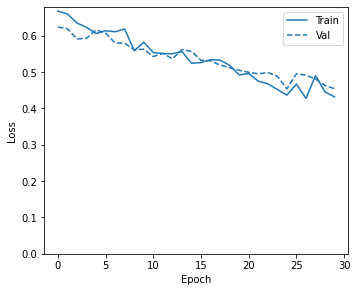

In [26]:
plot_metrics(baseline_history)

In [27]:
# for test
test_dataset = pd.read_csv(test_data_path, sep =";", index_col=[0])
test_dataset.head(20)

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,fit_class
ENSMUSG00000000563,1.0,-5.0,8.0,35.0,-15.0,-15.0,16.0,-14.0,4.0,-13.0,...,-6.0,-8.0,7.0,-3.0,-4.0,-11.0,-32.0,0.0,-3.0,0
ENSMUSG00000000120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000000378,0.0,5.0,-1.0,-3.0,1.0,-6.0,1.0,4.0,9.0,0.0,...,2.0,2.0,1.0,3.0,-2.0,-1.0,-1.0,-1.0,7.0,0
ENSMUSG00000000753,16.0,59.0,72.0,55.0,6.0,-17.0,23.0,12.0,49.0,-7.0,...,6.0,3.0,-27.0,5.0,0.0,-22.0,0.0,12.0,-8.0,2
ENSMUSG00000000743,-1.0,-12.0,8.0,5.0,-13.0,6.0,-4.0,-4.0,3.0,7.0,...,-2.0,5.0,0.0,1.0,4.0,-1.0,-5.0,0.0,2.0,0
ENSMUSG00000001924,32.0,37.0,73.0,64.0,79.0,47.0,93.0,59.0,64.0,61.0,...,23.0,27.0,51.0,35.0,36.0,32.0,77.0,23.0,36.0,1
ENSMUSG00000001555,18.0,-1.0,16.0,28.0,7.0,2.0,10.0,-5.0,12.0,-25.0,...,0.0,-3.0,26.0,-14.0,11.0,6.0,2.0,13.0,-8.0,2
ENSMUSG00000001056,-9.0,0.0,-1.0,10.0,10.0,2.0,-24.0,10.0,0.0,-1.0,...,1.0,-4.0,-32.0,-1.0,0.0,6.0,-1.0,11.0,8.0,2
ENSMUSG00000000805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000000732,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0


In [28]:
y_test = test_dataset.iloc[:,-1]
X_test = test_dataset.iloc[:,:-1]
X_test.shape, y_test.shape

((40, 682), (40,))

In [29]:
test_features = scaler.transform(np.array(X_test))
test_features = np.clip(test_features, -5, 5)
test_labels = np.array(y_test)

In [30]:
model.evaluate(x=test_features, y=test_labels)

2/2 [==============================] - 0s 14ms/step - loss: 0.9262 - sparse_categorical_accuracy: 0.5750


[0.9262251853942871, 0.574999988079071]